In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

PINECONE_API_KEY = os.environ['PINECONE_API_KEY']

# index 생성

In [3]:
from pinecone import Pinecone
# 클라이언트 생성
pinecone_client = Pinecone(api_key=PINECONE_API_KEY)

In [4]:
pinecone_client

## 클라이언트.create_index

In [5]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='embedding-3d',
    dimension=3,
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
)

{
    "name": "embedding-3d",
    "metric": "cosine",
    "host": "embedding-3d-o45zd0f.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 3,
    "deletion_protection": "disabled",
    "tags": null
}

In [5]:
index = pinecone_client.Index('embedding-3d')
index

c:\Users\Admin\miniconda3\envs\prompting_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

In [7]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


# pinecone data 형식

In [ ]:
index.upsert(
    vectors= [
        {'id' :'vec1', 'values' :[1.0,1.5,2.0], 'metadata': {'genre':'drama'}},
        {'id' :'vec2', 'values' :[2.0,1.5,0.5], 'metadata': {'genre':'action'}},
        {'id' :'vec3', 'values' :[0.1,0.3,0.5], 'metadata': {'genre':'drama'}},
        {'id' :'vec4', 'values' :[5.0,10.0,5.1], 'metadata': {'genre':'horror'}},
        {'id' :'vec5', 'values' :[3.5,2.2,1.1], 'metadata': {'genre':'comedy'}},
        {'id' :'vec6', 'values' :[0.5,1.0,1.5], 'metadata': {'genre':'drama'}}
    ],
    namespace='embedding-3d-ns1'
) #update + insert

{'upserted_count': 6}

# query

In [ ]:
response = index.query(
    namespace='embedding-3d-ns1',
    vector=[5.0,3.0,1.0], # 질의 벡터
    top_k=3, # 몇개 결과
    include_values=True,
    include_metadata=True,
    filter={'genre':{'$eq':'action'}}
)
response

{'matches': [{'id': 'vec2',
              'metadata': {'genre': 'action'},
              'score': 0.995270252,
              'values': [2.0, 1.5, 0.5]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 1}}

In [ ]:
response = index.query(
    # namespace='embedding-3d-ns1',
    vector=[5.0,3.0,1.0], # 질의 벡터
    top_k=3, # 몇개 결과
    include_values=True,
    include_metadata=True,
    filter={'genre':{'$eq':'action'}}
)
response

{'matches': [], 'namespace': '', 'usage': {'read_units': 1}}

# fetch

In [10]:
ns = 'embedding-3d-ns1'
for ids in index.list(namespace = ns):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


In [14]:
from itertools import chain
all_ids = list(chain.from_iterable(index.list(namespace = ns)))
resp = index.fetch(ids=all_ids, namespace=ns)
resp

FetchResponse(namespace='embedding-3d-ns1', vectors={'vec5': Vector(id='vec5', values=[3.5, 2.2, 1.1], metadata={'genre': 'comedy'}, sparse_values=None), 'vec2': Vector(id='vec2', values=[2.0, 1.5, 0.5], metadata={'genre': 'action'}, sparse_values=None), 'vec6': Vector(id='vec6', values=[0.5, 1.0, 1.5], metadata={'genre': 'drama'}, sparse_values=None), 'vec4': Vector(id='vec4', values=[5.0, 10.0, 5.1], metadata={'genre': 'horror'}, sparse_values=None), 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None), 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None)}, usage={'read_units': 1})

In [15]:
resp.vectors

{'vec5': Vector(id='vec5', values=[3.5, 2.2, 1.1], metadata={'genre': 'comedy'}, sparse_values=None),
 'vec2': Vector(id='vec2', values=[2.0, 1.5, 0.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec6': Vector(id='vec6', values=[0.5, 1.0, 1.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec4': Vector(id='vec4', values=[5.0, 10.0, 5.1], metadata={'genre': 'horror'}, sparse_values=None),
 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None)}

In [16]:
for vid, v in resp.vectors.items():
    print(vid, v.values)

vec5 [3.5, 2.2, 1.1]
vec2 [2.0, 1.5, 0.5]
vec6 [0.5, 1.0, 1.5]
vec4 [5.0, 10.0, 5.1]
vec3 [0.1, 0.3, 0.5]
vec1 [1.0, 1.5, 2.0]


# page - 1개 벡터씩 꺼내기

In [22]:
for id_page in index.list(namespace=ns):
    print('*', id_page)
    resp = index.fetch(ids=id_page, namespace=ns)
    for vid, v in resp.vectors.items():
        print(vid,v.values)
    

* ['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']
vec1 [1.0, 1.5, 2.0]
vec5 [3.5, 2.2, 1.1]
vec4 [5.0, 10.0, 5.1]
vec3 [0.1, 0.3, 0.5]
vec6 [0.5, 1.0, 1.5]
vec2 [2.0, 1.5, 0.5]


# 새로운 쿼리벡터 추가하기

In [29]:
ids = list(resp.vectors.keys())
values = [vec.values for vec in resp.vectors.values()]

In [30]:
ids.append('qv')
values.append([0.1,0.3,0.7])

# 시각화

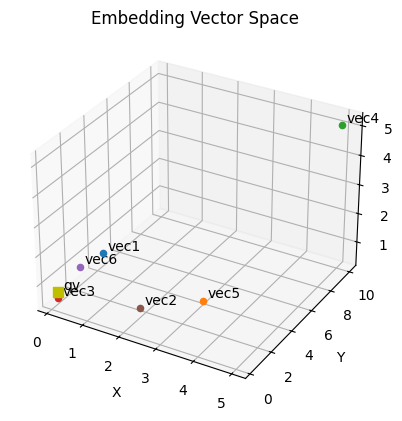

In [31]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()

name: "quickstart" 서버리스 인덱스 생성<br>
dic: 1024,

In [43]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."},
    {"id": "vec7", "text": "사과 파이는 전 세계적으로 사랑받는 고전적인 디저트입니다."},
    {"id": "vec8", "text": "애플의 운영 체제인 macOS는 강력하고 안전합니다."},
    {"id": "vec9", "text": "사과 주스는 건강에 좋은 음료로 알려져 있습니다."},
    {"id": "vec10", "text": "애플 워치는 사용자의 건강을 추적하는 데 도움이 되는 웨어러블 기기입니다."},
    {"id": "vec11", "text": "빨간 사과는 식료품점에서 흔히 볼 수 있습니다."},
    {"id": "vec12", "text": "아이튠즈와 같은 애플의 소프트웨어는 디지털 미디어 소비 방식을 변화시켰습니다."}
]

임베딩 모델<br>
multilingual-e5-large<br>
upsert()<br>
describe_index_stats()<br>
query_vector : "애플이라는 기술 회사에 대해 알려주세요."<br>
index.query()

In [44]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='quickstart',
    dimension=1024,
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
)

{
    "name": "quickstart",
    "metric": "cosine",
    "host": "quickstart-o45zd0f.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1024,
    "deletion_protection": "disabled",
    "tags": null
}

In [45]:
index = pinecone_client.Index('quickstart')

In [49]:
import torch
MODEL = 'intfloat/multilingual-e5-large'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [80]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(MODEL, device=device)
embedded_data = []
for item in data:
    doc_id = item['id']
    text = item['text']
    
    # 텍스트를 벡터로 변환
    vector = model.encode(text)
    
    # 새로운 딕셔너리 형식으로 변환하여 리스트에 추가
    embedded_data.append({'id': doc_id, 'values': vector.tolist(), 'metadata':{'text':text}})

embedded_data

[{'id': 'vec1',
  'values': [0.03120315819978714,
   -0.011677832342684269,
   0.006053668446838856,
   -0.028356142342090607,
   0.026437873020768166,
   -0.043653134256601334,
   -0.0072122071869671345,
   0.07913172245025635,
   0.021408749744296074,
   -0.016387058421969414,
   0.06488709896802902,
   0.011037622578442097,
   -0.028058502823114395,
   -0.006381398066878319,
   -0.013005427084863186,
   -0.013268860056996346,
   -0.027347272261977196,
   0.012715659104287624,
   0.005866419989615679,
   -0.008654279634356499,
   0.005601559299975634,
   0.004080944694578648,
   -0.042777713388204575,
   -0.0065704877488315105,
   -0.0031363051384687424,
   0.0016139800427481532,
   -0.013350682333111763,
   -0.017213711515069008,
   -0.020409177988767624,
   -0.04866515100002289,
   -0.02553148753941059,
   -0.0016814273549243808,
   -0.04217146709561348,
   -0.05277206376194954,
   -0.005039279814809561,
   0.030796758830547333,
   0.030413517728447914,
   0.023621056228876114,
   

In [81]:
index.upsert(
    vectors= embedded_data,
    namespace='quickstart-ns1'
) #update + insert

{'upserted_count': 12}

In [71]:
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'quickstart-ns1': {'vector_count': 12}},
 'total_vector_count': 12,
 'vector_type': 'dense'}

In [85]:
query_vector = "애플이라는 기술 회사에 대해 알려주세요."

In [86]:
embedded_query = model.encode(query_vector).tolist()
embedded_query

[0.017394382506608963,
 -0.008913278579711914,
 -0.028828686103224754,
 -0.018708297982811928,
 0.040170371532440186,
 -0.04340587183833122,
 -0.03753834217786789,
 0.05548166483640671,
 0.04252477362751961,
 -0.04414145275950432,
 0.03570961952209473,
 -0.005409644450992346,
 -0.044135432690382004,
 -0.018899796530604362,
 0.0030280330684036016,
 -0.03312183544039726,
 -0.03870704397559166,
 0.012989828363060951,
 0.015825768932700157,
 -0.036375440657138824,
 0.04193444177508354,
 -0.010117487981915474,
 -0.04633092135190964,
 -0.030050793662667274,
 0.001276977825909853,
 -0.0013027467066422105,
 -0.03889622911810875,
 -0.02553321048617363,
 0.011676455847918987,
 -0.07137040793895721,
 -0.00033047294709831476,
 -0.017774410545825958,
 -0.06036129966378212,
 -0.04162722826004028,
 -0.00859456229954958,
 0.020805977284908295,
 0.03323373571038246,
 0.024837877601385117,
 -0.035906460136175156,
 0.028289468958973885,
 -0.0339680090546608,
 0.0654716044664383,
 -0.028689302504062653,
 

In [87]:
response = index.query(
    namespace='quickstart-ns1',
    vector=embedded_query, # 질의 벡터
    top_k=3, # 몇개 결과
    # include_values=True,
    include_metadata=True
)
response

{'matches': [{'id': 'vec2',
              'metadata': {'text': '애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다.'},
              'score': 0.905899048,
              'values': []},
             {'id': 'vec4',
              'metadata': {'text': '애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 '
                                   '혁신했습니다.'},
              'score': 0.886487,
              'values': []},
             {'id': 'vec8',
              'metadata': {'text': '애플의 운영 체제인 macOS는 강력하고 안전합니다.'},
              'score': 0.856592238,
              'values': []}],
 'namespace': 'quickstart-ns1',
 'usage': {'read_units': 1}}

In [68]:
embeddings = pinecone_client.inference.embed(
    model="multilingual-e5-large",
    inputs=[d['text'] for d in data],
    parameters={"input_type": "passage", "truncate": "END"}
)

print(embeddings)

EmbeddingsList(
  model='multilingual-e5-large',
  vector_type='dense',
  data=[
    {'vector_type': dense, 'values': [0.0304107666015625, -0.020538330078125, ..., -0.030303955078125, 0.024017333984375]},
    {'vector_type': dense, 'values': [0.02178955078125, -0.0277099609375, ..., -0.0178070068359375, 0.0014896392822265625]},
    ... (8 more embeddings) ...,
    {'vector_type': dense, 'values': [0.007171630859375, -0.0170135498046875, ..., -0.033447265625, 0.03369140625]},
    {'vector_type': dense, 'values': [0.0238800048828125, -0.0401611328125, ..., -0.04461669921875, -0.00737762451171875]}
  ],
  usage={'total_tokens': 278}
)
